# EE5610-PRML : Program Assignment 1  

# EE20MTECH12001 : Shantanu Yadav

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import gzip

 1. Data generation

1)Use function MixGauss with appropriate parameters and produce a dataset with four classes and 30 samples per class: the classes must live in the 2D space and be centered on the corners of the unit square (0,0), (0,1) (1,1), (1,0), all with variance 0.3.

2)Obtain a 2-class train set [X, Y] by having data on opposite corners sharing the same class with labels +1 and -1. Example: if you generated the data following the order above, you can use a mapping like Y = 2*(1/2-mod(Y, 2));

3)Generate a test set [Xte, Yte] from the same distribution, starting with 200 samples per class.

4)Visualize both sets using scatter.



In [4]:
def MixGauss(mean,sigma,n):
    dataset={}
    d,nComp=mean.shape
    A=[np.random.multivariate_normal(mean[:,i],sigma*np.eye(d),size=(n)) for i in range(nComp)]
    X=np.array([])
    X=np.vstack(A[0])
    for i in range(1,len(A)):
        X=np.vstack((X,A[i]))
    Y=(np.array([[i+1]*n for i in range(nComp)])).flatten()

    dataset['data']=X
    dataset['target']=Y
    return dataset

(120, 2)
(800, 2)


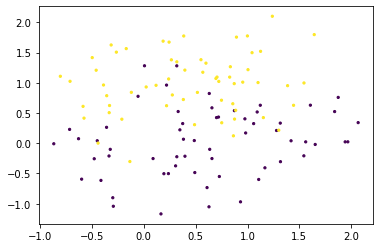

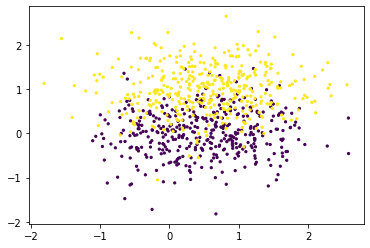

In [5]:

mean=np.array([[0,0],[0,1],[1,0],[1,1]]).T
sigma=0.3
n_train=30
n_test=200
train_dataset=MixGauss(mean,sigma,n_train)
test_dataset=MixGauss(mean,sigma,n_test)


X=train_dataset['data']
Y=train_dataset['target']
Xte=test_dataset['data']
Yte=test_dataset['target']

Y=2*(0.5-Y%2)
Yte=2*(0.5-Yte%2)

print(X.shape)
print(Xte.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1],5,Y)
plt.figure()
plt.scatter(Xte[:,0],Xte[:,1],5,Yte)


2. kNN classification

The k-Nearest Neighbors algorithm (kNN) assigns to a test point the most frequent label of its k closest examples in the training set. Study the code of function kNNClassify (for quick reference type help kNNClassify).

1) Use kNNClassify to generate predictions Yp for the 2-class data generated at Section 1. Pick a "reasonable" k.

2) Evaluate the classification performance (prediction error) by comparing the estimated labels Yp to the true labels Yte by: err = sum(Yp~=Yte)/length(Yte);

3) Visualize the obtained results, e.g. by plotting the wrongly classified points using different colors/markers:

4) Use the provided function separatingFkNN to visualize the separating function, or the areas of the 2D plane that are associated by the classifier with each class. Overlay the test points using scatter.



In [290]:
def SquareDist(X1,X2):
    # SQUAREDIST - computes Euclidean SQUARED distance matrix
    # E = distance(X1, X2)
    # X1 - (NxD) matrix
    # X2 - (MxD) matrix
    # Returns:
    # E - (NxM) Euclidean SQUARED distances between vectors in X1 and X2

    n=X1.shape[0]
    m=X2.shape[0]
    sq1=np.reshape(sum(np.multiply(X1,X1).T),(n,1))
    sq2=np.reshape(sum(np.multiply(X2,X2).T),(m,1))
    
    return sq1@np.ones((1,m))+np.ones((n,1))@sq2.T-2*X1@X2.T

In [291]:
def kNNClassify(Xtr,Ytr,k,Xte):
    
    n=Xtr.shape[0]
    if k>n:
        k=n
    ylab=np.unique(Ytr)
    ym=sum(ylab)/2
    
    Ytrm=Ytr-ym
    I=np.argsort(SquareDist(Xtr,Xte),axis=0)
    idx=I[0:k,:]
    
    if k==1:
        Ypred=Ytr[idx]
    else:
        val=[sum(Ytrm[idx][:,i])/k for i in range(len(idx[0,:]))]
        for i in range(len(val)):
            if val[i]==0:
                val[i]=Ytrm[idx][0,i]
        Ypred=np.sign(val)
    
    Ypred=Ypred+ym   
    return Ypred

Error= 0.2425


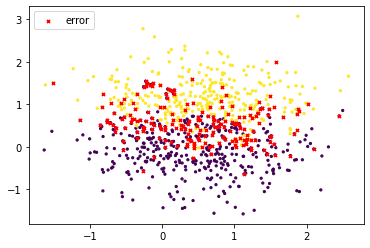

In [292]:
#Performance and Plot
k=2
Yp=kNNClassify(X,Y,k,Xte)
Yp=np.reshape(Yp,Yte.shape)
err=np.count_nonzero(Yp-Yte)/len(Yte)
print("Error=",err)
#Plot
l=[]
for i in range(len(Yte)):
    if(Yte[i]!=Yp[i]):
        l.append(i)
        
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(Xte[:,0],Xte[:,1],5,Yp)
ax.scatter(Xte[l,0],Xte[l,1],10,'r',marker='x',label='error')
plt.legend(loc='upper left')
plt.show()

#plt.figure()
#plt.scatter(Xte[:,0],Xte[:,1],5,Yte)



3. Parameter selection: what is a good value for k?

So far we considered an arbitrary choice for k. You will now use the function holdoutCVkNN for model selection.

1)Perform hold-out cross-validation using a percentage of the training set for validation. Note: for the suggested parameters rep=10 and pho=0.3, the hold-out procedure may be quite unstable.

a)Use a large range of candidate values for k (e.g. k=1,3,5...,21).
        
b)Repeat the process for rep times using at each iteration a random p of the training set for validation. Try rep=10, pho=0.3.

c)Plot the training and validation errors for the different values of k.

d)How would you now answer the question "what is the best value for k"?

2)How is the value of k affected by pho (percentage of points held out) and rep (number of repetitions e.g., 1, 5, 30, 50, 100)? What does a large number of repetitions provide?

3)Apply the model obtained by cross-validation (i.e., best k) to the test set and check if there is an improvement on the classification error over the result of Part 2.



In [265]:
def holdoutCVkNN(X,Y,pho,nrep,intK,plot=False,details=False):
    nK=len(intK)
    n=X.shape[0]
    ntr=math.ceil(n*(1-pho))
    
    Tm=np.zeros(nK)
    Ts=np.zeros(nK)
    Vm=np.zeros(nK)
    Vs=np.zeros(nK)
    
    ym=(max(Y)+min(Y))/2
    
    for rep in range(nrep):
        I=np.random.permutation(n)
        
        #Training Set
        Xtr=X[I[0:ntr],:]
        Ytr=Y[I[0:ntr]]
        
        #Validation Set
        Xvl=X[I[ntr+1:n-1],:]
        Yvl=Y[I[ntr+1:n-1]]
        
        ik=0
        for k in intK:
            
            trError=calcErr(np.reshape(kNNClassify(Xtr,Ytr,k,Xtr),Ytr.shape),Ytr)
            Tm[ik]=Tm[ik]+trError
            Ts[ik]=Ts[ik]+trError**2
            
            valError=calcErr(np.reshape(kNNClassify(Xvl,Yvl,k,Xvl),Yvl.shape),Yvl)
            Vm[ik]=Vm[ik]+valError
            Vs[ik]=Vs[ik]+valError**2
        
            if details: print("k=",k," iter=",rep+1," valErr=",valError," trErr=",trError,"Mean of error on training set for k=",k,"is =",Tm[ik],"Mean of error on Validation set for k=",k,"is =",Tm[ik],"\n")
            
            ik=ik+1
            
        if details: print(".......................................................................\n")

    #Average over trials
    Tm=Tm/nrep
    Ts=Ts/nrep - Tm**2
    
    Vm=Vm/nrep
    Vs=Vs/nrep - Vm**2
    
    if plot: 
        plt.figure()
        plt.scatter(intK,Vm,25)
        plt.xlabel("k Values")
        plt.ylabel("Validation Mean Error")
        
        plt.figure()
        plt.scatter(intK,Tm,25)
        plt.xlabel("k Values")
        plt.ylabel("Training Mean Error")
        
    return intK[np.argmin(Vm)]
    
def calcErr(Yp,Y):
    return np.count_nonzero(Yp-Y)/len(Y)

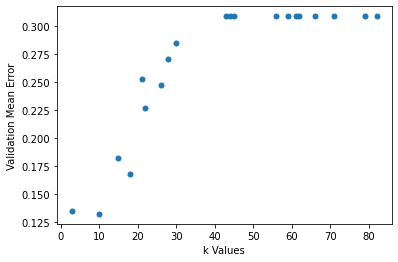

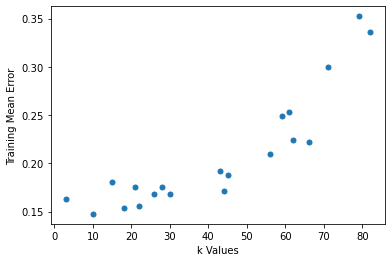

In [269]:
initialk=random.randint(1,10)
finalk=random.randint(45,90)
intK=random.sample(range(initialk,finalk),20)
optimal_k=holdoutCVkNN(X,Y,0.3,10,intK,details=False,plot=True)

Optimal k Value is obtained by finding that k value which gives the least validation mean error.

In [270]:
print("Optimal k Value :",optimal_k)

Optimal k Value : 10


0.17375


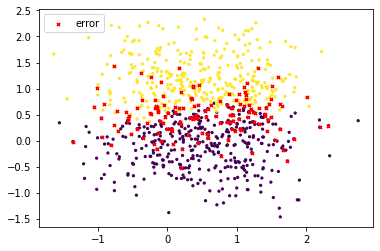

In [271]:
#Cross-Validation
Yp=kNNClassify(X,Y,optimal_k,Xte)
Yp=np.reshape(Yp,Yte.shape)
err=np.count_nonzero(Yp-Yte)/len(Yte)
print(err)
#Plot
l=[]
for i in range(len(Yte)):
    if(Yte[i]!=Yp[i]):
        l.append(i)
        
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(Xte[:,0],Xte[:,1],5,Yp)
ax.scatter(Xte[l,0],Xte[l,1],10,'r',marker='x',label='error')
plt.legend(loc='upper left')
plt.show()

#plt.figure()
#plt.scatter(Xte[:,0],Xte[:,1],5,Yte)


4. size of training data and kNN regression

(a) Dependence on training size: Evaluate the performance as the size of the training set
grows, e.g., n = {50, 100, 300, 500,...}. How would you choose a good range for k as n
changes? What can you say about the stability of the solution? Check by repeating the
validation multiple times.

(b) Try classifying more difficult datasets, for instance, by increasing the variance or
adding noise by randomly flipping the labels on the training set.

(c) Modify the function kNNClassify to handle a) multi-class problems.

In [272]:
def checkPerformance(training_size,klistSize,mean=np.array([[0,0],[0,1],[1,0],[1,1]]).T,sigma=0.3):
    k_list=np.array([])
    error_list=np.array([])
    for n in training_size:
        
        train_dataset=MixGauss(mean,sigma,n)
        test_dataset=MixGauss(mean,sigma,n_test)
        X=train_dataset['data']
        Y=train_dataset['target']
        Xte=test_dataset['data']
        Yte=test_dataset['target']
        
        Y=2*(0.5-Y%2)
        Yte=2*(0.5-Yte%2)
        
        initialK=random.randint(1,10)
        finalK=random.randint(30,90)
        intK=random.sample(range(initialK,finalK),klistSize)
        
        optimal_k=holdoutCVkNN(X,Y,0.3,10,intK)
        k_list=np.append(k_list,optimal_k)
        
        Yp=kNNClassify(X,Y,optimal_k,Xte)
        Yp=np.reshape(Yp,Yte.shape)
        err=np.count_nonzero(Yp-Yte)/len(Yte)
        error_list=np.append(error_list,err)
        print("Training Set Size =",n,"| k Values used :",intK,"| Error =",err,"\n")
    
    plt.figure()
    plt.scatter(k_list,error_list)
    plt.xlabel("Optimal k Values")
    plt.ylabel("Error in prediction")
    
    return k_list

Training Set Size = 399 | k Values used : [31, 9, 8, 19, 24, 10, 28, 11, 4, 14, 23, 30, 22, 33, 2] | Error = 0.23875 

Training Set Size = 539 | k Values used : [23, 58, 32, 79, 81, 53, 9, 62, 78, 43, 72, 73, 21, 12, 50] | Error = 0.2 

Training Set Size = 733 | k Values used : [9, 24, 51, 22, 15, 68, 27, 41, 55, 29, 42, 66, 38, 7, 19] | Error = 0.1875 

Training Set Size = 634 | k Values used : [32, 3, 38, 24, 10, 8, 63, 47, 29, 30, 39, 18, 50, 40, 54] | Error = 0.18875 

Training Set Size = 196 | k Values used : [59, 49, 38, 64, 88, 12, 20, 81, 40, 21, 14, 48, 56, 78, 39] | Error = 0.2125 

Training Set Size = 190 | k Values used : [44, 15, 79, 73, 87, 47, 8, 74, 78, 10, 30, 62, 43, 38, 60] | Error = 0.19375 

Training Set Size = 632 | k Values used : [10, 8, 72, 34, 31, 43, 68, 49, 51, 15, 16, 41, 52, 45, 13] | Error = 0.1975 

Training Set Size = 863 | k Values used : [29, 12, 41, 21, 40, 27, 42, 19, 34, 37, 1, 33, 16, 18, 23] | Error = 0.24875 

Training Set Size = 705 | k Values 

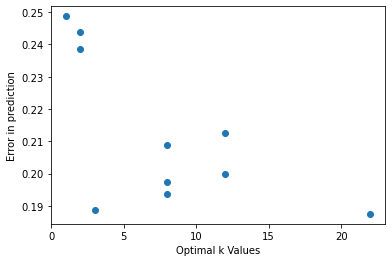

In [160]:
n=random.sample(range(50,1000),10)
k_list=checkPerformance(n,15)

Training Set Size = 898 | k Values used : [61, 15, 56, 8, 83] | Error = 0.30625 

Training Set Size = 701 | k Values used : [63, 8, 56, 49, 39] | Error = 0.32375 

Training Set Size = 443 | k Values used : [41, 65, 30, 51, 26] | Error = 0.28875 

Training Set Size = 166 | k Values used : [9, 39, 24, 12, 7] | Error = 0.29875 

Training Set Size = 919 | k Values used : [7, 50, 68, 47, 13] | Error = 0.3225 



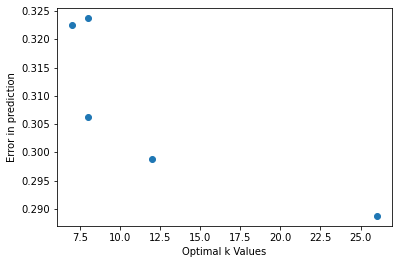

In [164]:
n=random.sample(range(50,1000),5)
k_list=checkPerformance(n,5,sigma=0.8)

In [277]:
#Modified kNNClassify

def kNNClassify(Xtr,Ytr,k,Xte):
    
    n=Xtr.shape[0]
    if k>n:
        k=n
    ylab=np.unique(Ytr)
    ym=math.ceil(sum(np.unique(Ytr))/len(np.unique(Ytr)))
    
    Ytrm=Ytr-ym
    I=np.argsort(SquareDist(Xtr,Xte),axis=0)
    idx=I[0:k,:]
    
    if k==1:
        Ypred=Ytr[idx]
    else:
        val=[sum(Ytrm[idx][:,i])/k for i in range(len(idx[0,:]))]
        for i in range(len(val)):
            if val[i]==0:
                val[i]=Ytrm[idx][0,i]
        Ypred=np.floor(val)
    
    Ypred=Ypred+ym   
    return Ypred

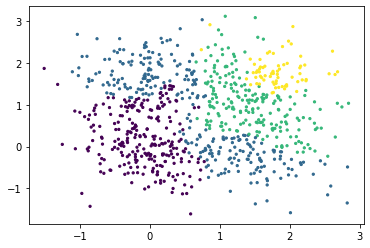

In [278]:
mean=np.array([[0,0],[0,1.5],[1.5,0],[1.5,1.5]]).T
sigma=0.3
n_train=30
n_test=200
train_dataset=MixGauss(mean,sigma,n_train)
test_dataset=MixGauss(mean,sigma,n_test)


X=train_dataset['data']
Y=train_dataset['target']
Xte=test_dataset['data']
Yte=test_dataset['target']

k=12
Yp=kNNClassify(X,Y,k,Xte)
Yp=np.reshape(Yp,Yte.shape)

#Plot
l=[]
for i in range(len(Yte)):
    if(Yte[i]!=Yp[i]):
        l.append(i)
        
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(Xte[:,0],Xte[:,1],5,2*Yp)
plt.show()

5.Digit classification on MNIST data

(a) Design a KNN classifier to classify the images in MNIST dataset as one of the 10 digits. The 28x28 images may be flattened to arrive at a 784 dimensional vector.

(b)Empirically determine the most suitable error function, and the corresponding k to
maximize the performance on the cross-validation experiments.

(c) Apply these values to evaluate the performance on the test dataset.

(d) Create a confusion matrix to understand the most confused classes (digits).

(e) Suggest alternate ways to improve the performance.

In [279]:
def load_mnist(filename, type, n_datapoints):
    # MNIST Images have 28*28 pixels dimension
    image_size = 28
    f = gzip.open(filename)
    
    if(type == 'image'):
        f.read(16)    # Skip Non-Image information
        buf = f.read(n_datapoints * image_size * image_size)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(n_datapoints, image_size, image_size, 1)
    elif(type == 'label'):
        f.read(8) # Skip Inessential information
        buf = f.read(n_datapoints)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        data = data.reshape(n_datapoints, 1)
    return data

Index:  27405
Training Set: 
Label: [6]


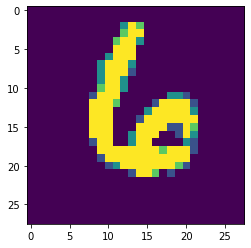

Index:  3768
Training Set: 
Label: [0]


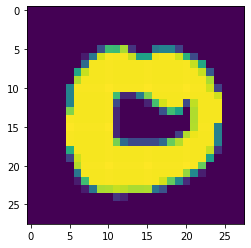

In [280]:
# Training Dataset
train_size = 60000
test_size = 10000
# dirpath = '/content/drive/My Drive/02 MNIST Digit Recognition/'
dirpath = ''
X_train = load_mnist('train-images.gz', 'image', train_size)
Y_train = load_mnist('train-labels.gz', 'label', train_size)
X_test = load_mnist('test-images.gz', 'image', test_size)
Y_test = load_mnist('test-labels.gz', 'label', test_size)
#To verify whether the data is loaded properly, the image and label are randomly selected and visualized
index = random.randint(0, train_size)
print('Index: ', index)
print('Training Set: ')
print('Label:', Y_train[index])
img = np.asarray(X_train[index]).squeeze()
plt.imshow(img)
plt.show()

index = random.randint(0, test_size)
print('Index: ', index)
print('Training Set: ')
print('Label:', Y_test[index])
img = np.asarray(X_test[index]).squeeze()
plt.imshow(img)
plt.show()


In [281]:
def kNNClassify(Xtr,Ytr,k,Xte):
    
    n=Xtr.shape[0]
    if k>n:
        k=n
    ylab=np.unique(Ytr)
    ym=math.ceil(sum(np.unique(Ytr))/len(np.unique(Ytr)))
    
    Ytrm=Ytr-ym
    I=np.argsort(SquareDist(Xtr,Xte),axis=0)
    idx=I[0:k,:]
    
    if k==1:
        Ypred=Ytr[idx]
    else:
        val=[sum(Ytrm[idx][:,i])/k for i in range(len(idx[0,:]))]
        for i in range(len(val)):
            if val[i]==0:
                val[i]=Ytrm[idx][0,i]
        Ypred=np.floor(val)
    
    Ypred=Ypred+ym   
    return Ypred

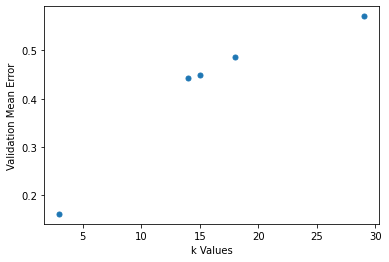

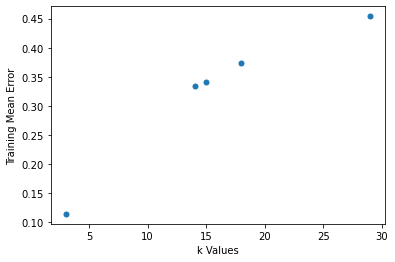

In [283]:
p=0.05
tr_size=int(train_size*p)
te_size=int(test_size*p)
Ytr=Y_train[0:tr_size]
Yte=Y_test[0:te_size]

Xtr=np.reshape(X_train[0:tr_size].squeeze().flatten(),(tr_size,28*28))
Xte=np.reshape(X_test[0:te_size].squeeze().flatten(),(te_size,28*28))
Yp=kNNClassify(Xtr,Ytr,2,Xte)

intK=random.sample(range(1,30),5)
optimal_k=holdoutCVkNN(Xtr,Ytr,0.3,10,intK,plot=True)

In [284]:
print("optimal k :",optimal_k)
Yp=kNNClassify(Xtr,Ytr,optimal_k,Xte)
Yp=np.reshape(Yp,Yte.shape)
err=np.count_nonzero(Yp-Yte)/len(Yte)
print("Error :",err)

optimal k : 3
Error : 0.214


In [285]:
def confusionMatrix(Yp,Y):
    if(len(Yp)!=len(Y)):
        print("The dimensions of parameters dont match")
        exit()
    
    conf_mat=dict(zip(np.unique(Yp),[0]*len(np.unique(Yp))))
    for i in range(Yp.shape[0]):
        if(Yp[i]!=Y[i]):
            conf_mat[int(Y[i])]+=1
    return conf_mat

In [286]:
conf_mat=confusionMatrix(Yp,Yte)
print("Confusion Matrix = ",conf_mat)

Confusion Matrix =  {0.0: 2, 1.0: 0, 2.0: 21, 3.0: 11, 4.0: 19, 5.0: 10, 6.0: 5, 7.0: 5, 8.0: 13, 9.0: 21}
